In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Constants
batch_size = 128
num_classes = 10
input_dim = 784

# Hyperparameters
lr = 1.0
hidden_dim = 1200

In [4]:
# iris = datasets.load_iris()
training_data = datasets.MNIST(root='data', train=True, download=True, transform=ToTensor())
training_set, validation_set = torch.utils.data.random_split(training_data, [50000, 10000])
test_data = datasets.MNIST(root='data', train=False, download=True, transform=ToTensor())

training_loader = DataLoader(training_set, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(validation_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [5]:
num_batches = int(len(training_set) / batch_size) + 1
denom = 2 ** num_batches  - 1

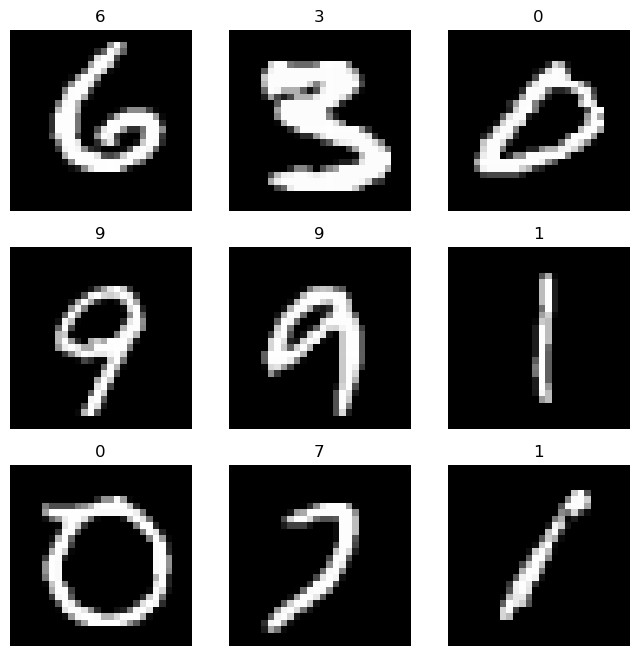

In [6]:
# Visualize the data
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

# No need to normalize. The data values are already between 0 and 1

In [7]:
# print(img.shape)
print(len(training_set),len(validation_set))

50000 10000


In [8]:
# x, y = torch.from_numpy(X).float(), torch.from_numpy(Y).long()
# x.shape, y.shape

In [9]:
model = nn.Sequential(
    nn.Linear(in_features=input_dim, out_features=hidden_dim, bias=False),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(in_features=hidden_dim, out_features=hidden_dim, bias=False),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(in_features=hidden_dim, out_features=num_classes, bias=False),
)

In [10]:
ce_loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr)

In [11]:
def train_one_epoch(epoch_index, tb_writer):
    running_loss = 0.
    last_loss = 0.

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(training_loader):
        # Every data instance is an input + label pair
        inputs, labels = data

        inputs = inputs.view(-1, 784)

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        ################## WE CAN AVERAGE ACROSS MULTIPLE W SAMPLES HERE BEFORE DOING loss.backward() #########################
        outputs = model(inputs)

        # Compute the loss and its gradients
        loss = ce_loss(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        if i % 100 == 99:
            last_loss = running_loss / 100 # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            tb_x = epoch_index * len(training_loader) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.

    return last_loss

In [12]:
# Initializing in a separate cell so we can easily add more epochs to the same run
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/MNIST_trainer_{}'.format(timestamp))
epoch_number = 0

val_loss = []
val_accuracy = []

test_loss = []
test_accuracy = []

EPOCHS = 300

best_vloss = 1_000_000.
num_vbatches = int(len(validation_set) / batch_size) + 1
vdenom = 2 ** num_vbatches - 1

num_tbatches = int(len(test_data) / batch_size) + 1
tdenom = 2 ** num_tbatches - 1

scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.998)

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss = train_one_epoch(epoch_number, writer)

    # We don't need gradients on to do reporting
    model.train(False)

    running_vloss = 0.0
    correct = 0
    for i, vdata in enumerate(validation_loader):
        vinputs, vlabels = vdata
        vinputs = vinputs.view(-1, 784)
        voutputs = model(vinputs)
        _, predicted = torch.max(voutputs, 1)
        correct += torch.sum(vlabels == predicted)
        vloss = ce_loss(voutputs, vlabels)
        running_vloss += vloss.item()

    avg_vloss = running_vloss / (i + 1)
    val_loss.append(avg_vloss)
    val_accuracy.append(100 * float(correct)/ len(validation_set))
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))
    print('valid accuracy {}'.format(val_accuracy[-1]))

    # Log the running loss averaged per batch
    # for both training and validation
    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss, 'Validation' : avg_vloss },
                    epoch_number + 1)
    writer.flush()

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = './models/SGD-dropout/model_{}_{}'.format(timestamp, epoch_number)
        torch.save(model.state_dict(), model_path)
    
    # Update the learning rate
    scheduler.step()
    
    ########## NOT SURE HOW TO CHANGE MOMENTUM LINEARLY ##########################
    
    running_tloss = 0.0
    correct = 0

    for i, tdata in enumerate(test_loader):
        tinputs, tlabels = tdata
        tinputs = tinputs.view(-1, 784)
        toutputs = model(tinputs)
        _, predicted = torch.max(toutputs, 1)
        correct += torch.sum(tlabels == predicted)
        tloss = ce_loss(voutputs, vlabels)
        running_tloss += tloss.item()

    avg_tloss = running_tloss / (i + 1)

    test_loss.append(avg_tloss)
    test_accuracy.append(100 * float(correct)/ len(test_data))
    print('test accuracy {}'.format(test_accuracy[-1]))

    epoch_number += 1

EPOCH 1:
  batch 100 loss: 1.083117382824421
  batch 200 loss: 0.4206805904209614
  batch 300 loss: 0.29018919050693515
LOSS train 0.29018919050693515 valid 0.19412441740307626
valid accuracy 94.11
test accuracy 94.27
EPOCH 2:
  batch 100 loss: 0.21487657099962235
  batch 200 loss: 0.20827333185821773
  batch 300 loss: 0.18133973848074675
LOSS train 0.18133973848074675 valid 0.12834056693164608
valid accuracy 96.05
test accuracy 96.37
EPOCH 3:
  batch 100 loss: 0.16929349567741156
  batch 200 loss: 0.15723982758820057
  batch 300 loss: 0.1414078575000167
LOSS train 0.1414078575000167 valid 0.10571945604832866
valid accuracy 96.57
test accuracy 96.75
EPOCH 4:
  batch 100 loss: 0.148173599652946
  batch 200 loss: 0.1329672410339117
  batch 300 loss: 0.12956810221076012
LOSS train 0.12956810221076012 valid 0.08808978432435778
valid accuracy 97.23
test accuracy 97.34
EPOCH 5:
  batch 100 loss: 0.12220355555415154
  batch 200 loss: 0.11819904915988445
  batch 300 loss: 0.1192546957731247
LO

  batch 100 loss: 0.029328753921436145
  batch 200 loss: 0.028498774794861674
  batch 300 loss: 0.03709884520270862
LOSS train 0.03709884520270862 valid 0.062620608533933
valid accuracy 98.46
test accuracy 98.46
EPOCH 39:
  batch 100 loss: 0.03394110966299195
  batch 200 loss: 0.028708453679573722
  batch 300 loss: 0.030277160443365574
LOSS train 0.030277160443365574 valid 0.07098924722876164
valid accuracy 98.27
test accuracy 98.14
EPOCH 40:
  batch 100 loss: 0.02796826745267026
  batch 200 loss: 0.03522970259538852
  batch 300 loss: 0.036509328905958684
LOSS train 0.036509328905958684 valid 0.07410535240001369
valid accuracy 98.21
test accuracy 98.32
EPOCH 41:
  batch 100 loss: 0.036829827029141594
  batch 200 loss: 0.03783220371464267
  batch 300 loss: 0.03751438186969608
LOSS train 0.03751438186969608 valid 0.07501611498455647
valid accuracy 98.23
test accuracy 98.46
EPOCH 42:
  batch 100 loss: 0.03334552592830733
  batch 200 loss: 0.029827017809730023
  batch 300 loss: 0.033691969

test accuracy 98.34
EPOCH 75:
  batch 100 loss: 0.02003917104026186
  batch 200 loss: 0.023090250130189817
  batch 300 loss: 0.02303950760848238
LOSS train 0.02303950760848238 valid 0.07469961963491913
valid accuracy 98.49
test accuracy 98.31
EPOCH 76:
  batch 100 loss: 0.01911245190705813
  batch 200 loss: 0.021924961472468567
  batch 300 loss: 0.01905864870022924
LOSS train 0.01905864870022924 valid 0.07358545429488464
valid accuracy 98.53
test accuracy 98.47
EPOCH 77:
  batch 100 loss: 0.014544282587157795
  batch 200 loss: 0.022047546976973535
  batch 300 loss: 0.022347274386884237
LOSS train 0.022347274386884237 valid 0.07121725977003159
valid accuracy 98.46
test accuracy 98.56
EPOCH 78:
  batch 100 loss: 0.023139860621304253
  batch 200 loss: 0.01839955909177661
  batch 300 loss: 0.017844020917182207
LOSS train 0.017844020917182207 valid 0.07252942137471755
valid accuracy 98.42
test accuracy 98.54
EPOCH 79:
  batch 100 loss: 0.021638635029812576
  batch 200 loss: 0.02154787637366

  batch 300 loss: 0.01600900016805099
LOSS train 0.01600900016805099 valid 0.0694404675190601
valid accuracy 98.67
test accuracy 98.56
EPOCH 112:
  batch 100 loss: 0.016186204479909067
  batch 200 loss: 0.012917774308316438
  batch 300 loss: 0.014870574481019503
LOSS train 0.014870574481019503 valid 0.07345635914311913
valid accuracy 98.49
test accuracy 98.54
EPOCH 113:
  batch 100 loss: 0.015251541463039758
  batch 200 loss: 0.015681600571988384
  batch 300 loss: 0.014008354702418728
LOSS train 0.014008354702418728 valid 0.07328078302694256
valid accuracy 98.65
test accuracy 98.67
EPOCH 114:
  batch 100 loss: 0.013014754648138479
  batch 200 loss: 0.01684218059739578
  batch 300 loss: 0.01421483928710586
LOSS train 0.01421483928710586 valid 0.07576480191567532
valid accuracy 98.69
test accuracy 98.49
EPOCH 115:
  batch 100 loss: 0.012098130180397675
  batch 200 loss: 0.00826633638696876
  batch 300 loss: 0.013180938225741557
LOSS train 0.013180938225741557 valid 0.07329450164055329
va

test accuracy 98.42
EPOCH 148:
  batch 100 loss: 0.008996613198061425
  batch 200 loss: 0.0123586261580067
  batch 300 loss: 0.007307582403232118
LOSS train 0.007307582403232118 valid 0.08618234945569833
valid accuracy 98.47
test accuracy 98.57
EPOCH 149:
  batch 100 loss: 0.006688311322695881
  batch 200 loss: 0.00888690698427922
  batch 300 loss: 0.006651465916011148
LOSS train 0.006651465916011148 valid 0.08296848952407725
valid accuracy 98.53
test accuracy 98.5
EPOCH 150:
  batch 100 loss: 0.007175610397257515
  batch 200 loss: 0.010915760352618235
  batch 300 loss: 0.00908010488495961
LOSS train 0.00908010488495961 valid 0.07325460389698561
valid accuracy 98.64
test accuracy 98.58
EPOCH 151:
  batch 100 loss: 0.006759251057691245
  batch 200 loss: 0.008001756799794748
  batch 300 loss: 0.008828993505894688
LOSS train 0.008828993505894688 valid 0.07741820166783431
valid accuracy 98.7
test accuracy 98.56
EPOCH 152:
  batch 100 loss: 0.007508191415978444
  batch 200 loss: 0.005092999

  batch 200 loss: 0.006467973547045176
  batch 300 loss: 0.012658506603529532
LOSS train 0.012658506603529532 valid 0.07980557456074719
valid accuracy 98.61
test accuracy 98.52
EPOCH 185:
  batch 100 loss: 0.009400744627877771
  batch 200 loss: 0.007661861482285985
  batch 300 loss: 0.012762390364996464
LOSS train 0.012762390364996464 valid 0.08557477958642665
valid accuracy 98.56
test accuracy 98.62
EPOCH 186:
  batch 100 loss: 0.006781309877223976
  batch 200 loss: 0.010787870608992308
  batch 300 loss: 0.009593311570664582
LOSS train 0.009593311570664582 valid 0.08175900824317989
valid accuracy 98.57
test accuracy 98.56
EPOCH 187:
  batch 100 loss: 0.004592447931719903
  batch 200 loss: 0.012314644043989915
  batch 300 loss: 0.010271608176358313
LOSS train 0.010271608176358313 valid 0.08583847552654333
valid accuracy 98.53
test accuracy 98.49
EPOCH 188:
  batch 100 loss: 0.006968171849816827
  batch 200 loss: 0.009669094219957515
  batch 300 loss: 0.006960117576379616
LOSS train 0.0

  batch 300 loss: 0.006297858143975646
LOSS train 0.006297858143975646 valid 0.08370235701240054
valid accuracy 98.64
test accuracy 98.58
EPOCH 221:
  batch 100 loss: 0.0070876107293287305
  batch 200 loss: 0.004928517980111451
  batch 300 loss: 0.007997815450096937
LOSS train 0.007997815450096937 valid 0.08240061417202497
valid accuracy 98.66
test accuracy 98.63
EPOCH 222:
  batch 100 loss: 0.005717249131934068
  batch 200 loss: 0.0038735490493104407
  batch 300 loss: 0.00351551860466202
LOSS train 0.00351551860466202 valid 0.08492208964434177
valid accuracy 98.61
test accuracy 98.63
EPOCH 223:
  batch 100 loss: 0.005663363713584601
  batch 200 loss: 0.004473832482352691
  batch 300 loss: 0.004988176035203651
LOSS train 0.004988176035203651 valid 0.08316023005139685
valid accuracy 98.66
test accuracy 98.64
EPOCH 224:
  batch 100 loss: 0.0035298145387787374
  batch 200 loss: 0.005945992284724042
  batch 300 loss: 0.003043221875066706
LOSS train 0.003043221875066706 valid 0.086005602572

LOSS train 0.0022900406934060415 valid 0.09077377827378758
valid accuracy 98.61
test accuracy 98.57
EPOCH 257:
  batch 100 loss: 0.0022830757957905236
  batch 200 loss: 0.006073883611012149
  batch 300 loss: 0.003866810099997142
LOSS train 0.003866810099997142 valid 0.0849690222523488
valid accuracy 98.58
test accuracy 98.74
EPOCH 258:
  batch 100 loss: 0.0024578055067070183
  batch 200 loss: 0.004222710781979084
  batch 300 loss: 0.002430374193601299
LOSS train 0.002430374193601299 valid 0.09054384926721928
valid accuracy 98.56
test accuracy 98.61
EPOCH 259:
  batch 100 loss: 0.002346128415997626
  batch 200 loss: 0.0033118039368218886
  batch 300 loss: 0.00391843434886539
LOSS train 0.00391843434886539 valid 0.08705359834978112
valid accuracy 98.55
test accuracy 98.64
EPOCH 260:
  batch 100 loss: 0.004071679178735081
  batch 200 loss: 0.00496543627643689
  batch 300 loss: 0.00270204956924168
LOSS train 0.00270204956924168 valid 0.08450870728014112
valid accuracy 98.7
test accuracy 98

LOSS train 0.0031089639683395376 valid 0.08741864288748646
valid accuracy 98.63
test accuracy 98.62
EPOCH 293:
  batch 100 loss: 0.0015397402107017654
  batch 200 loss: 0.004013825914084918
  batch 300 loss: 0.0022920359426251125
LOSS train 0.0022920359426251125 valid 0.091062734931375
valid accuracy 98.61
test accuracy 98.67
EPOCH 294:
  batch 100 loss: 0.004112448734644261
  batch 200 loss: 0.002143917722789155
  batch 300 loss: 0.0032157401150027455
LOSS train 0.0032157401150027455 valid 0.0869808951074981
valid accuracy 98.59
test accuracy 98.63
EPOCH 295:
  batch 100 loss: 0.0031534567975737104
  batch 200 loss: 0.004698273049840083
  batch 300 loss: 0.004142177395186764
LOSS train 0.004142177395186764 valid 0.09286024568362199
valid accuracy 98.56
test accuracy 98.59
EPOCH 296:
  batch 100 loss: 0.0041458624199516335
  batch 200 loss: 0.002320456666852877
  batch 300 loss: 0.0028299525227797064
LOSS train 0.0028299525227797064 valid 0.0916754729198227
valid accuracy 98.61
test ac

In [13]:
data = {}
data['test-loss'] = test_loss
data['test-accuracy'] = test_accuracy
data['validation-loss'] = val_loss
data['validation-accuracy'] = val_accuracy

with open('./models/SGD-dropout/test-loss', 'wb') as f:
    pickle.dump(data, f)

# Test 

In [14]:
model.train(False)

running_tloss = 0.0
correct = 0

for i, tdata in enumerate(test_loader):
    tinputs, tlabels = tdata
    tinputs = tinputs.view(-1, 784)
    toutputs = model(tinputs)
    _, predicted = torch.max(toutputs, 1)
    correct += torch.sum(tlabels == predicted)
    tloss = ce_loss(voutputs, vlabels)
    running_tloss += tloss.item()

avg_tloss = running_tloss / (i + 1)
print('LOSS test {}'.format(avg_tloss))
print("Number of correct predictions {}".format(correct))

print("Accuracy: {:.2f}".format(100 * float(correct)/ len(test_data)))


LOSS test 4.9586291424930096e-05
Number of correct predictions 9852
Accuracy: 98.52


In [15]:
model_path = './models/SGD-dropout/model_{}_{}'.format(timestamp, epoch_number)
torch.save(model.state_dict(), model_path)

In [16]:
# for step in range(3000):
#     pre = model(x)
#     ce = ce_loss(pre, y)
#     kl = kl_loss(model)
#     cost = ce + kl_weight*kl
    
#     optimizer.zero_grad()
#     cost.backward()
#     optimizer.step()
    
# _, predicted = torch.max(pre.data, 1)
# total = y.size(0)
# correct = (predicted == y).sum()
# print('- Accuracy: %f %%' % (100 * float(correct) / total))
# print('- CE : %2.2f, KL : %2.2f' % (ce.item(), kl.item()))

# Test Model

In [17]:
# def draw_plot(predicted) :
#     fig = plt.figure(figsize = (16, 5))

#     ax1 = fig.add_subplot(1, 2, 1)
#     ax2 = fig.add_subplot(1, 2, 2)

#     z1_plot = ax1.scatter(X[:, 0], X[:, 1], c = Y)
#     z2_plot = ax2.scatter(X[:, 0], X[:, 1], c = predicted)

#     plt.colorbar(z1_plot,ax=ax1)
#     plt.colorbar(z2_plot,ax=ax2)

#     ax1.set_title("REAL")
#     ax2.set_title("PREDICT")

#     plt.show()

In [18]:
# pre = model(x)
# _, predicted = torch.max(pre.data, 1)
# draw_plot(predicted)

In [19]:
# Bayesian Neural Network will return different outputs even if inputs are same.
# In other words, different plots will be shown every time forward method is called.
# pre = model(x)
# _, predicted = torch.max(pre.data, 1)
# draw_plot(predicted)